# apply polar framework to generated antonyms

## loading generated antonyms

In [2]:
# loading model
from gensim.test.utils import datapath, get_tmpfile
from gensim.models import KeyedVectors
current_model = KeyedVectors.load_word2vec_format("./Dataset/word2vec_norm", binary=True)

In [2]:
# loading antonyms of topic country
# with open('./generated_antonyms/country_related_antonyms', 'r') as f:
#     list_antonym = [line.strip('\n').split(' ') for line in f.readlines()]

with open('./generated_antonyms/country50_related_antonyms.txt', 'r') as f:
    list_antonym = [line.strip('\n').split(' ') for line in f.readlines()]

In [3]:
list_antonym[:10]

[['buddhism', 'catholic'],
 ['descend', 'risen'],
 ['limited', 'universal'],
 ['advancement', 'failure'],
 ['disbelieve', 'meditating'],
 ['disadvantage', 'lead'],
 ['communal', 'personal'],
 ['modern', 'primitive'],
 ['good', 'sinister'],
 ['calm', 'heated']]

## decide the size of antonym vector

In [4]:
## Find the antonym difference vectors
# the dir vector of each antonym pair
import numpy as np
antonymy_vector = []
for each_word_pair in list_antonym:
    antonymy_vector.append(current_model[each_word_pair[0]]- current_model[each_word_pair[1]])
antonymy_vector = np.array(antonymy_vector)

print(antonymy_vector.shape)

(470, 300)


### select first antonym vector which has maximal variance

In [5]:
from tqdm import tqdm_notebook as tqdm

variance_antonymy_vector_inverse = np.linalg.pinv(np.transpose(antonymy_vector))

embedding_matrix = []
total_words = 0
for each_word in tqdm(current_model.vocab):
    total_words += 1
    # multiple
    new_vector = np.matmul(variance_antonymy_vector_inverse,current_model[each_word])
    
    embedding_matrix.append(new_vector)

In [6]:
print(len(embedding_matrix)) # how many words in Vocab
print(len(embedding_matrix[0])) # how many diemensions of each word

212390
470


In [7]:
variance_list = []

embedding_matrix = np.array(embedding_matrix)
#calcaulate variance for each colunms, 1411 colunms , 1411 variances
for each_dimension in tqdm(range(embedding_matrix.shape[1])):
    variance_list.append(np.var(embedding_matrix[:,each_dimension]))

In [8]:
variance_antonymy_vector = [each for each in sorted(range(len(variance_list)), key=lambda i: variance_list[i], reverse=True)]
print(len(variance_antonymy_vector))
max_variance_antonym = variance_antonymy_vector[0]
print('The index of antonym vector which has the maximal variance in Vocab is: ', ' ', max_variance_antonym)

470
The index of antonym vector which has the maximal variance in Vocab is:418


### generate the ORTHOGONAL DIMENSION Order using maximal vairance antonym vector 

In [9]:
from scipy.spatial.distance import cosine as scipy_cosine
from collections import defaultdict

t1 = np.array(antonymy_vector)

dimension_similarity_matrix = defaultdict(dict)
for index_1, each_dim1 in enumerate(tqdm(t1)):
    for index_2, each_dim2 in enumerate(t1):
        dimension_similarity_matrix[index_1][index_2] = abs(1-scipy_cosine(each_dim1, each_dim2))

def get_set_score(final_list, each_dim):
    final_output = 0.0
    for each_vec in final_list:
        final_output += dimension_similarity_matrix[each_vec][each_dim]
    return final_output/(len(final_list))

def select_subset_dimension(dim_vector, num_dim, max_variance_antonym):
    working_list = np.array(dim_vector)
    working_position_index = [i for i in range(working_list.shape[0])]
    final_position_index = [] #store the final index of selected of antonyms
    final_position_index.append(max_variance_antonym)
    # delete it from original antonym sets
    working_position_index.remove(max_variance_antonym)
    # select other num_dim-1 antonyms
    for test_count in tqdm(range(num_dim-1)):
        min_dim = None
        min_score = float('inf')
        for temp_index, each_dim in enumerate(working_position_index):
            temp_score = get_set_score(final_position_index, each_dim)
            if temp_score< min_score:
                min_score= temp_score
                min_dim = each_dim
        final_position_index.append(min_dim)
        working_position_index.remove(min_dim)

    return final_position_index

In [10]:
# select 300 dimensions.  In other words , select 300 different antonyms
selected_antonyms = select_subset_dimension(antonymy_vector, 300, max_variance_antonym)

In [11]:
selected_antonyms[:10]

[418, 64, 355, 305, 293, 65, 98, 77, 179, 258]

## Transformation into polar space

In [12]:
from numpy import linalg
from gensim.scripts.glove2word2vec import glove2word2vec
from gensim.test.utils import datapath, get_tmpfile
from gensim.models import KeyedVectors
import gensim

def transform_to_antonym_space(current_model, output_file_path, binary, current_antonymy_vector_inverse):
    #current_antonymy_vector_inverse is ((dir)T)-1
    #embeddding_size is dynamic, it depends on how many antonym pairs we have selected
    embedding_size = current_antonymy_vector_inverse.shape[0]   ##CHANGE THIS ACCORDINGLY!!!
    print('New model size is ',(len(current_model.vocab),embedding_size))

    temp_file = None
    
    if binary:
        temp_file = open(output_file_path,'wb')
        temp_file.write(str.encode(str(len(current_model.vocab))+' '+str(embedding_size)+'\n'))
    else:
        temp_file = open(output_file_path,'w')
        temp_file.write(str(len(current_model.vocab))+' '+str(embedding_size)+'\n')

    total_words = 0
    for each_word in tqdm(current_model.vocab):
        total_words += 1
        if binary:
            temp_file.write(str.encode(each_word+' '))
        else:
            temp_file.write(each_word+' ')

        new_vector = np.matmul(current_antonymy_vector_inverse, current_model[each_word])
        # normalization vector
        new_vector = new_vector/linalg.norm(new_vector)
        
        if binary:
            temp_file.write(new_vector)
            temp_file.write(str.encode('\n'))
        else:
            temp_file.write(str(new_vector))
            temp_file.write('\n')


    temp_file.close()

In [13]:
#standard normalization for word vectors
#Standardization makses datapoint normal distribution
def standard_normal_dist_model(model, new_filename):
    embedding_matrix = []
    embedding_vocab = []

    temp_file = open(new_filename,'wb')
    temp_file.write(str.encode(str(model.vectors.shape[0])+' '+str(model.vectors.shape[1])+'\n'))
    
    for each_word in tqdm(model.vocab):
        embedding_matrix.append(model[each_word])
        embedding_vocab.append(each_word)
    
    embedding_matrix = np.array(embedding_matrix)
    
    print('The shape of embedding matrix is {}'.format(embedding_matrix.shape))
    
    #standard normalization
    norm_embedding_matrix = (embedding_matrix - embedding_matrix.mean(0))/ embedding_matrix.std(0)
    
    for word_counter, each_word in enumerate(tqdm(embedding_vocab)):
        temp_file.write(str.encode(each_word+' '))
        new_vector = norm_embedding_matrix[word_counter]
        temp_file.write(new_vector)
        temp_file.write(str.encode('\n'))
        
    del embedding_matrix
    del embedding_vocab
    temp_file.close()

In [14]:
def generate_embedding_path(current_model, embedding_path, binary, selected_antonyms):
    curr_antonym_vector = antonymy_vector[selected_antonyms]
    #calcaulate Moore-Penrose inverse
    curr_antonymy_vector_inverse = np.linalg.pinv(np.transpose(curr_antonym_vector))
    print(curr_antonymy_vector_inverse.shape)

    transform_to_antonym_space(current_model, embedding_path, binary, curr_antonymy_vector_inverse)

In [15]:
%%time

curr_dim = 300
#embedding_path = './Dataset/country_antonym_'+str(curr_dim)+'.bin'
embedding_path = './Dataset/country50_antonym_'+str(curr_dim)+'.bin'
generate_embedding_path(current_model, embedding_path,True, selected_antonyms)

print('loading the model')
temp_model = gensim.models.KeyedVectors.load_word2vec_format(embedding_path, binary=True)
print('loading done..')

# std_nrml_embedding_path = './Dataset/country_antonym_'+str(curr_dim)+'_StdNrml.bin'
std_nrml_embedding_path = './Dataset/country50_antonym_'+str(curr_dim)+'_StdNrml.bin'
standard_normal_dist_model(temp_model, std_nrml_embedding_path)

(300, 300)
New model size is(212390, 300)



loading the model
loading done..



The shape of embedding matrix is (212390, 300)



Wall time: 38 s


## loading trained polar-framework model and visualize

In [17]:
import gensim
# norm_300_path = './Dataset/country_antonym_300.bin'
# std_300_path = './Dataset/country_antonym_300_StdNrml.bin'
norm_300_path = './Dataset/country50_antonym_300.bin'
std_300_path = './Dataset/country50_antonym_300_StdNrml.bin'
#loading new word vectors
norm_300_vector = gensim.models.KeyedVectors.load_word2vec_format(norm_300_path, binary=True)
std_300_vector = gensim.models.KeyedVectors.load_word2vec_format(std_300_path, binary=True)

In [17]:
std_300_vector.most_similar('japan')

[('stageshow', 0.9329258799552917),
 ('xbase', 0.9313914775848389),
 ('yokoyama', 0.9279221296310425),
 ('weerasethakul', 0.9271926879882812),
 ('hayao', 0.9245770573616028),
 ('gensui', 0.9243185520172119),
 ('gladly', 0.9234952926635742),
 ('usu', 0.9216287732124329),
 ('cankili', 0.9205949306488037),
 ('odious', 0.9203158617019653)]

In [18]:
select_antonyms = [list_antonym[i] for i in selected_antonyms]
select_antonyms[:10]

[['die', 'wast'],
 ['deterioration', 'improvement'],
 ['detrain', 'do'],
 ['dwarf', 'large'],
 ['adult', 'embryonic'],
 ['curtailed', 'lengthy'],
 ['china', 'russia'],
 ['bold', 'craven'],
 ['major', 'slight'],
 ['harmonious', 'unfriendly']]

In [22]:
this_vector = std_300_vector['japan']
this_dict = {}
for index,value in enumerate(this_vector):
    this_dict[index] = value
    
sorted_this_dict = sorted(this_dict.items(), key= lambda item : abs(item[1]), reverse=True )
for key,value in sorted_this_dict[:5]:
    print(value)
    print(key)
    print(select_antonyms[key])

3.9325018
289
['enclose', 'exclude']
-3.0819502
202
['happy', 'sinister']
3.0578098
12
['front', 'unimportant']
2.7944682
10
['antecedent', 'current']
-2.767696
182
['city', 'country']


In [23]:
import matplotlib.pyplot as plt
def plotPolar(left, right, value):
    fig, ax1 = plt.subplots()
    fig.set_figheight(1)
    fig.set_figwidth(10)

    val = 0
    ar = np.arange(-10,11) 
    ax1.plot(ar, np.zeros_like(ar) + val, '.')
    ax1.plot(value, 0, 'd', linewidth=2, markersize=20, color='r')
    ax1.set_ylabel(left, color='b',rotation=0, size=20, labelpad=50)
    ax1.set_yticks([])
    ax1.set_xticks(ar)
    ax1.spines['right'].set_visible(False)
    ax1.spines['top'].set_visible(False)
    ax1.spines['left'].set_visible(False)
    ax1.spines['bottom'].set_visible(False)

    ax2 = ax1.twinx()
    ax2.set_ylabel(right, color='r',rotation=0, size=20, labelpad=50)
    ax2.set_yticks([])
    ax1.grid(False)
    ax2.grid(False)
    ax2.spines['right'].set_visible(False)
    ax2.spines['top'].set_visible(False)
    ax2.spines['left'].set_visible(False)
    ax2.spines['bottom'].set_visible(False)
    
    
    
    fig.tight_layout()
    plt.show()

In [24]:
def getMeaningOfWord(word, antonyms, model, show_polars ):
    
    this_vector = model[word]
    this_dict = {}
    for index,value in enumerate(this_vector):
        this_dict[index] = value
    
    sorted_this_dict = sorted(this_dict.items(), key= lambda item : abs(item[1]), reverse=True )
    
    for i,v in sorted_this_dict[:show_polars]:
        cur_value = v
        leftPolar = antonyms[i][0]
        rightPolar = antonyms[i][1]
        plotPolar(rightPolar,leftPolar, cur_value)
        

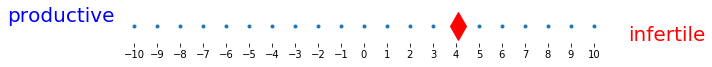

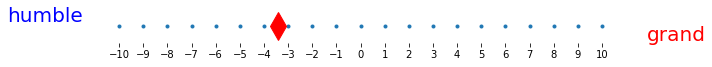

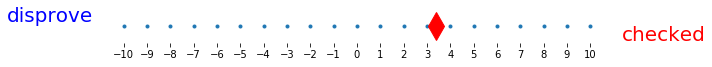

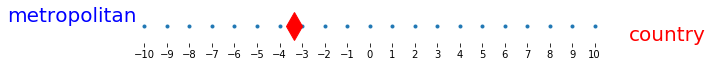

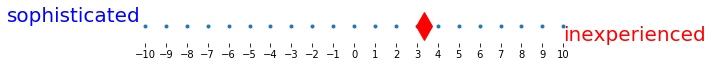

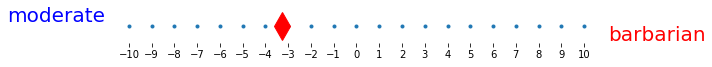

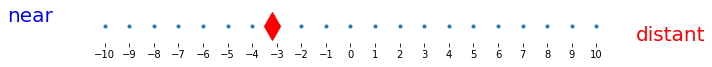

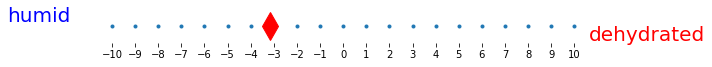

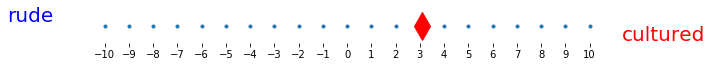

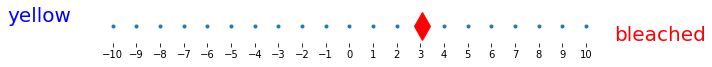

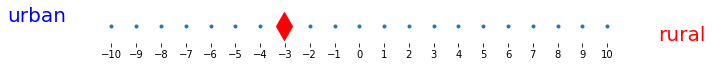

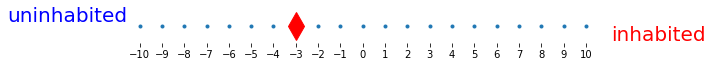

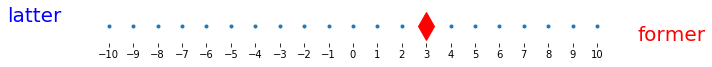

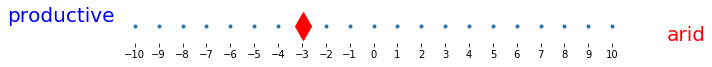

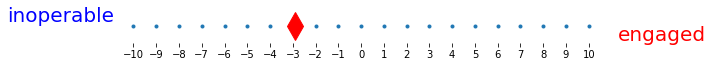

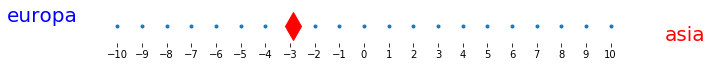

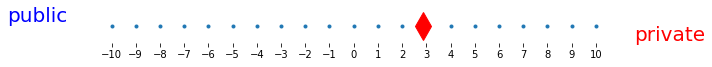

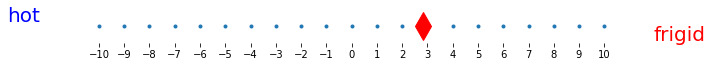

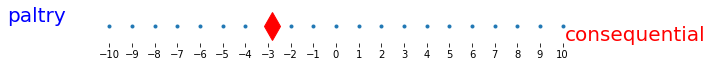

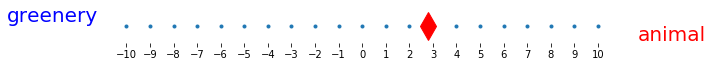

In [25]:
getMeaningOfWord("england", select_antonyms, std_300_vector, 20)

### t-SNE country word embedding visualize

In [32]:
# load country words
# find countries vector and store it
import pandas as pd
from sklearn.manifold import TSNE
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv('./Dataset/countries/countries of the world.csv')
# df = pd.read_csv('./Dataset/countries/Countries-Continents.csv')

def tSNE(df, model):
    final_countries = []
    #filter country which is not in model
    for country in df['Country']:
        c = str(country).lower()
        country = c.strip()
        if country in model.vocab:
            final_countries.append(country)
    vector = model[final_countries]

    tsne = TSNE(n_components=2,init='pca',verbose=1)
    embedd = tsne.fit_transform(vector)

    plt.figure(figsize=(16,12))
    # plt.scatter(embedd[:,0], embedd[:,1])
    for i in range(len(final_countries)):
        x = embedd[i][0]
        y = embedd[i][1]
        plt.scatter(embedd[i,0], embedd[i,1])
        # plt.text(x, y, final_countries[i])
        plt.annotate(final_countries[i],	
                     xy=(x, y),
                     xytext=(5, 3),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 167 samples in 0.001s...
[t-SNE] Computed neighbors for 167 samples in 0.005s...
[t-SNE] Computed conditional probabilities for sample 167 / 167
[t-SNE] Mean sigma: 0.342366
[t-SNE] KL divergence after 250 iterations with early exaggeration: 59.267670
[t-SNE] KL divergence after 1000 iterations: 0.370733


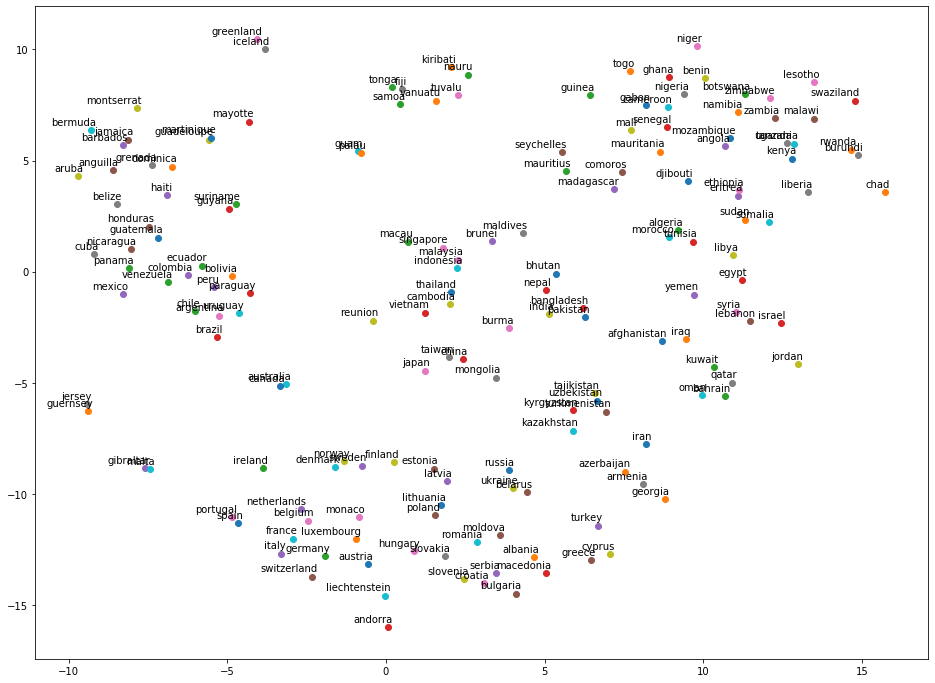

In [33]:
# before polar framework
tSNE(df, current_model)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 167 samples in 0.001s...
[t-SNE] Computed neighbors for 167 samples in 0.006s...
[t-SNE] Computed conditional probabilities for sample 167 / 167
[t-SNE] Mean sigma: 0.160899
[t-SNE] KL divergence after 250 iterations with early exaggeration: 58.150764
[t-SNE] KL divergence after 850 iterations: 0.451566


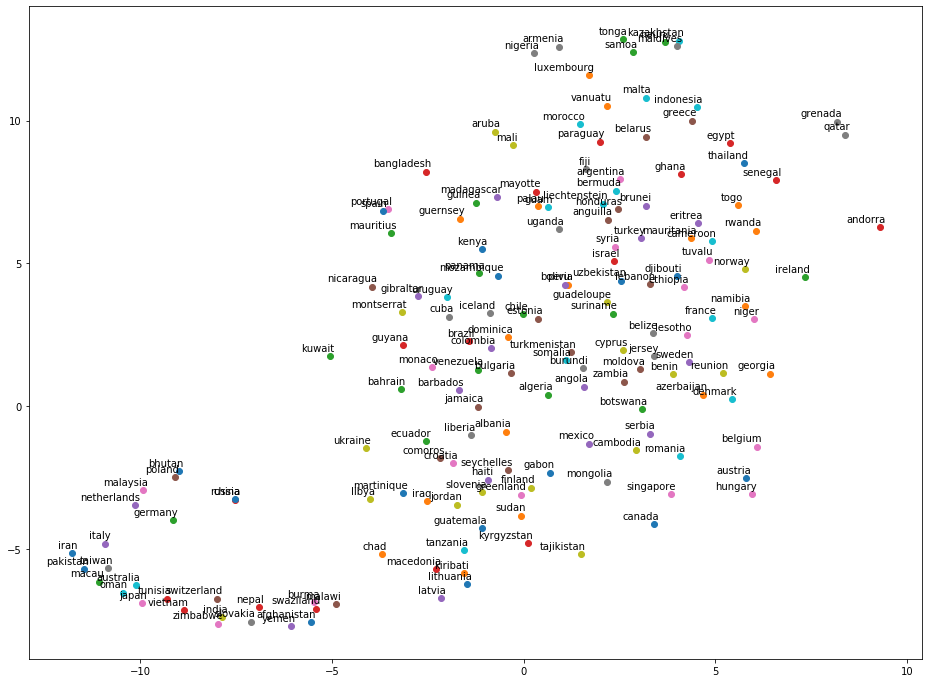

In [34]:
## after polar framework transforamtion
tSNE(df, norm_300_vector)

In [26]:
def plot_lines(word, select_antonyms, model, show_polars):
    this_vector = model[word]
    this_dict = {}
    for index,value in enumerate(this_vector):
        this_dict[index] = value
    
    sorted_this_dict = sorted(this_dict.items(), key= lambda item : abs(item[1]), reverse=True)

    this_color = []
    values = []
    left_words, right_words = [], []
    for x,y in sorted_this_dict:
        if y <= 0:
            this_color.append('red')
        else:
            this_color.append('green')
        values.append(y)
        left_words.append(select_antonyms[x][0])
        right_words.append(select_antonyms[x][1])
    # Draw plot
    index = [i for i in range(show_polars)]
    plt.figure(figsize=(14,10), dpi= 80)
    plt.hlines(y=index, xmin=0, xmax=values, color=this_color, alpha=0.4, linewidth=5)

    # Decorations
    plt.gca().set(ylabel='$words$', xlabel='$score$')
    plt.title('The preference of word '+ word, fontdict={'size':20})
    plt.yticks(index, left_words, fontsize=12)
    
    plt.grid(linestyle='--', alpha=0.5)
    plt.show()

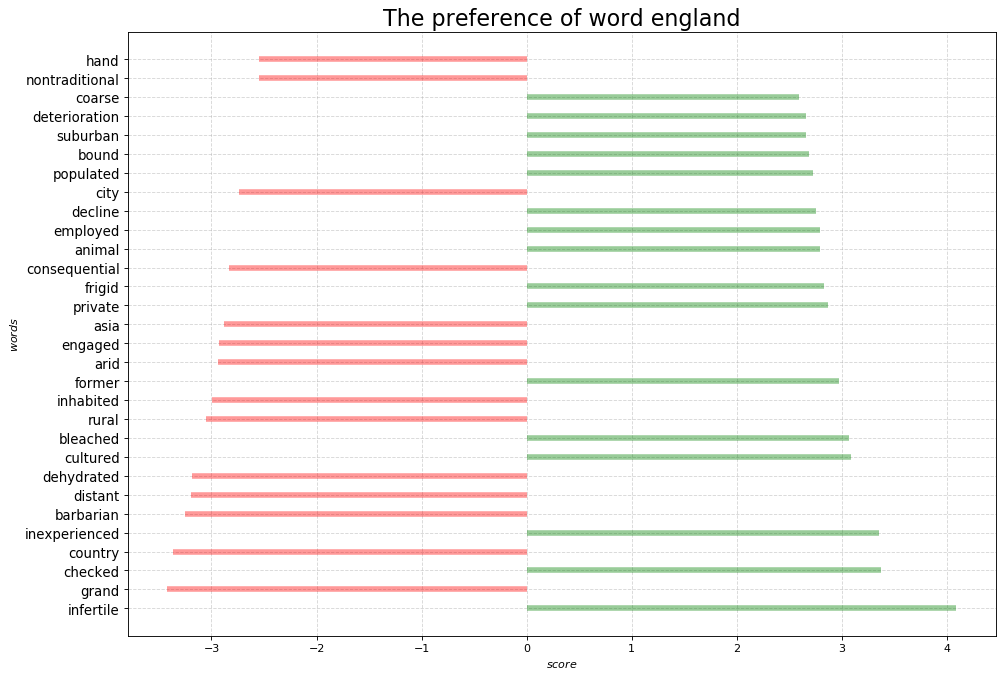

In [27]:
plot_lines("england", select_antonyms, std_300_vector, 30)      